<a href="https://colab.research.google.com/github/navidh86/perturbseq-10701/blob/master/Combine_classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
# # ONLY FOR COLAB
# !git clone https://github.com/navidh86/perturbseq-10701.git
# %cd ./perturbseq-10701
# !pip install fastparquet tqdm scikit-learn



In [42]:

import os
import pickle
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from sklearn.metrics import f1_score, classification_report

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Using device: cuda


In [43]:
from data.reference_data_classification import (
    PairPerturbSeqDataset,
    perturbseq_collate_2,
    get_dataloader,
)

train_loader = get_dataloader(
    parquet_path="data/tf_gene_expression_labeled_v2.parquet",
    tf_sequences_path="data/tf_sequences.pkl",
    gene_sequences_path="data/gene_sequences_4000bp.pkl",
    batch_size=128,
    type="train",
    majority_fraction=0.005,
)

val_loader = get_dataloader(
    parquet_path="data/tf_gene_expression_labeled_v2.parquet",
    tf_sequences_path="data/tf_sequences.pkl",
    gene_sequences_path="data/gene_sequences_4000bp.pkl",
    batch_size=256,
    type="val",
    majority_fraction=0.005,
)

test_loader = get_dataloader(
    parquet_path="data/tf_gene_expression_labeled_v2.parquet",
    tf_sequences_path="data/tf_sequences.pkl",
    gene_sequences_path="data/gene_sequences_4000bp.pkl",
    batch_size=256,
    type="test",
    majority_fraction=0.005,
)

print("Train batches:", len(train_loader.dataset))
print("Val batches:", len(val_loader.dataset))
print("Test batches:", len(test_loader.dataset))



Train batches: 10845
Val batches: 2324
Test batches: 2325


In [44]:
# load NT sequence embeddings
tf_embed_cache = pickle.load(open("./embeds/tf_cls.pkl", "rb"))
gene_embed_cache = pickle.load(open("./embeds/gn_cls.pkl", "rb"))

# ensure everything is torch tensors
for k in tf_embed_cache:
    if not isinstance(tf_embed_cache[k], torch.Tensor):
        tf_embed_cache[k] = torch.tensor(tf_embed_cache[k], dtype=torch.float32)

for k in gene_embed_cache:
    if not isinstance(gene_embed_cache[k], torch.Tensor):
        gene_embed_cache[k] = torch.tensor(gene_embed_cache[k], dtype=torch.float32)

first_tf = next(iter(tf_embed_cache.values()))
first_gene = next(iter(gene_embed_cache.values()))
print("TF emb dim:", first_tf.shape)
print("Gene emb dim:", first_gene.shape)


TF emb dim: torch.Size([1280])
Gene emb dim: torch.Size([1280])


In [45]:
train_ds = train_loader.dataset
val_ds = val_loader.dataset
test_ds = test_loader.dataset

# Use all TF/gene names across ALL splits
combined_df = pd.concat([train_ds.df, val_ds.df, test_ds.df]).reset_index(drop=True)

tf_names = sorted(combined_df["tf_name"].unique().tolist())
gene_names = sorted(combined_df["gene_name"].unique().tolist())

tf_id_map = {name: idx for idx, name in enumerate(tf_names)}
gene_id_map = {name: idx for idx, name in enumerate(gene_names)}

print("Num TF IDs:", len(tf_id_map))
print("Num Gene IDs:", len(gene_id_map))

# check if each TF/gene has an embedding
missing_tf = [n for n in tf_names if n not in tf_embed_cache]
missing_gene = [n for n in gene_names if n not in gene_embed_cache]
print("Missing TF in cache:", len(missing_tf))
print("Missing gene in cache:", len(missing_gene))


Num TF IDs: 223
Num Gene IDs: 4539
Missing TF in cache: 0
Missing gene in cache: 0


In [46]:
def one_hot(index, num_classes):
    v = torch.zeros(num_classes, dtype=torch.float32)
    v[index] = 1.0
    return v


In [47]:
class TFgeneHybridMLP(nn.Module):
    def __init__(self, tf_embed_cache, gene_embed_cache, tf_id_map, gene_id_map,
                 hidden_dim=1024, num_classes=3):
        super().__init__()

        self.tf_cache = tf_embed_cache
        self.gene_cache = gene_embed_cache
        self.tf_id_map = tf_id_map
        self.gene_id_map = gene_id_map

        self.num_tfs = len(tf_id_map)
        self.num_genes = len(gene_id_map)

        seq_dim = next(iter(tf_embed_cache.values())).shape[0]

        # FINAL INPUT SIZE:
        # TF_seq + Gene_seq + interaction + TF_onehot + Gene_onehot
        in_dim = seq_dim*3 + self.num_tfs + self.num_genes

        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.1),

            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ReLU(),

            nn.Linear(hidden_dim//2, 128),
            nn.ReLU(),

            nn.Linear(128, num_classes)
        )

    def forward(self, batch_x):
        X_list = []

        for item in batch_x:
            tf_name = item["tf_name"]
            gene_name = item["gene_name"]

            tf_seq = self.tf_cache[tf_name]
            gene_seq = self.gene_cache[gene_name]
            interaction = tf_seq * gene_seq

            tf_onehot = torch.zeros(self.num_tfs)
            gene_onehot = torch.zeros(self.num_genes)

            tf_onehot[self.tf_id_map[tf_name]] = 1.0
            gene_onehot[self.gene_id_map[gene_name]] = 1.0

            vec = torch.cat([tf_seq, gene_seq, interaction, tf_onehot, gene_onehot])
            X_list.append(vec)

        X = torch.stack(X_list).to(device)
        return self.net(X)

    def extract_hidden(self, batch_x):
      """Return the hidden representation before the final classification layer.
        Input format must match forward(): a list of dicts with tf_name, gene_name.
      """
      X_list = []

      for item in batch_x:
          tf_name = item["tf_name"]
          gene_name = item["gene_name"]

          tf_seq = self.tf_cache[tf_name]
          gene_seq = self.gene_cache[gene_name]
          interaction = tf_seq * gene_seq

          # One-hot IDs
          tf_onehot = torch.zeros(self.num_tfs)
          gene_onehot = torch.zeros(self.num_genes)
          tf_onehot[self.tf_id_map[tf_name]] = 1.0
          gene_onehot[self.gene_id_map[gene_name]] = 1.0

          vec = torch.cat([tf_seq, gene_seq, interaction, tf_onehot, gene_onehot])
          X_list.append(vec)

      X = torch.stack(X_list).to(device)

      # Pass through all layers EXCEPT the LAST (classification layer)
      hidden = X
      # layer 1
      hidden = self.net[0](hidden)
      hidden = self.net[1](hidden)
      hidden = self.net[2](hidden)
      # layer 2
      hidden = self.net[3](hidden)
      hidden = self.net[4](hidden)
      hidden = self.net[5](hidden)
      # layer 3
      hidden = self.net[6](hidden)
      hidden = self.net[7](hidden)
      # layer 4
      hidden = self.net[8](hidden)
      hidden = self.net[9](hidden)

      return hidden  # shape: (batch, 128)



In [48]:
loss_fn = nn.CrossEntropyLoss()

def train_one_epoch(model, loader, optimizer):
    model.train()
    total_loss, total_correct, total_samples = 0.0, 0, 0

    for batch_x, batch_y in loader:
        batch_y = batch_y.to(device)

        logits = model(batch_x)
        loss = loss_fn(logits, batch_y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        preds = logits.argmax(dim=1)
        total_loss += loss.item() * len(batch_y)
        total_correct += (preds == batch_y).sum().item()
        total_samples += len(batch_y)

    return total_loss / total_samples, total_correct / total_samples


@torch.no_grad()
def eval_model(model, loader):
    model.eval()
    total_loss, total_correct, total_samples = 0.0, 0, 0
    all_preds, all_labels = [], []

    for batch_x, batch_y in loader:
        batch_y = batch_y.to(device)

        logits = model(batch_x)
        loss = loss_fn(logits, batch_y)

        preds = logits.argmax(dim=1)

        total_loss += loss.item() * len(batch_y)
        total_correct += (preds == batch_y).sum().item()
        total_samples += len(batch_y)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

    avg_loss = total_loss / total_samples
    acc = total_correct / total_samples
    macro_f1 = f1_score(all_labels, all_preds, average="macro")

    return avg_loss, acc, macro_f1, all_labels, all_preds


In [49]:
model = TFgeneHybridMLP(
    tf_embed_cache=tf_embed_cache,
    gene_embed_cache=gene_embed_cache,
    tf_id_map=tf_id_map,
    gene_id_map=gene_id_map,
    hidden_dim=1024,
    num_classes=3,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

best_val_f1 = -1
best_state = None

for epoch in range(1, 31):
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
    _, _, train_f1, _, _ = eval_model(model, train_loader)

    # validation
    val_loss, val_acc, val_f1, _, _ = eval_model(model, val_loader)

    print(
        f"Epoch {epoch:02d} | "
        f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} Train F1: {train_f1:.4f} | "
        f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}"
    )

    # save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_state = model.state_dict()
        torch.save(best_state, "best_hybrid_model.pt")
        print(f"*** Saved best model at epoch {epoch} (Val F1={val_f1:.4f})")



Epoch 01 | Train Loss: 1.0996, Train Acc: 0.3402 Train F1: 0.1751 | Val Loss: 1.0973, Val Acc: 0.3563, Val F1: 0.1751
*** Saved best model at epoch 1 (Val F1=0.1751)
Epoch 02 | Train Loss: 1.0978, Train Acc: 0.3471 Train F1: 0.1594 | Val Loss: 1.0993, Val Acc: 0.3141, Val F1: 0.1594
Epoch 03 | Train Loss: 1.0977, Train Acc: 0.3521 Train F1: 0.2732 | Val Loss: 1.0968, Val Acc: 0.3683, Val F1: 0.2684
*** Saved best model at epoch 3 (Val F1=0.2684)
Epoch 04 | Train Loss: 1.0965, Train Acc: 0.3540 Train F1: 0.1751 | Val Loss: 1.0973, Val Acc: 0.3563, Val F1: 0.1751
Epoch 05 | Train Loss: 1.0969, Train Acc: 0.3518 Train F1: 0.1751 | Val Loss: 1.0960, Val Acc: 0.3563, Val F1: 0.1751
Epoch 06 | Train Loss: 1.0904, Train Acc: 0.3730 Train F1: 0.1594 | Val Loss: 1.1274, Val Acc: 0.3141, Val F1: 0.1594
Epoch 07 | Train Loss: 1.0429, Train Acc: 0.4391 Train F1: 0.4899 | Val Loss: 0.9760, Val Acc: 0.5000, Val F1: 0.4613
*** Saved best model at epoch 7 (Val F1=0.4613)
Epoch 08 | Train Loss: 0.9355,

In [50]:
# Load best model
model.load_state_dict(torch.load("best_hybrid_model.pt"))

test_loss, test_acc, test_f1, y_true, y_pred = eval_model(model, test_loader)

print("\n=== FINAL TEST RESULTS ===")
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)
print("Test Macro F1:", test_f1)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))



=== FINAL TEST RESULTS ===
Test Loss: 0.600830147086933
Test Accuracy: 0.7436559139784946
Test Macro F1: 0.7481602529884613

Classification Report:
              precision    recall  f1-score   support

           0     0.7125    0.7637    0.7372       766
           1     0.8697    0.8126    0.8402       731
           2     0.6699    0.6643    0.6671       828

    accuracy                         0.7437      2325
   macro avg     0.7507    0.7468    0.7482      2325
weighted avg     0.7468    0.7437    0.7446      2325



In [20]:
# =========================
# Extract latent embeddings
# =========================
model.eval()

embeds = []
labels = []

for batch_x, batch_y in train_loader:
    h = model.extract_hidden(batch_x)        # hidden layer output
    embeds.append(h.detach().cpu())          # <-- FIXED
    labels.extend(batch_y.cpu().numpy())

embeds = torch.cat(embeds).numpy()
labels = np.array(labels)

print("Embeddings shape:", embeds.shape)
print("Labels shape:", labels.shape)

Embeddings shape: (10845, 128)
Labels shape: (10845,)


In [22]:
# =========================
# UMAP
# =========================
!pip install umap-learn --quiet
import umap

reducer = umap.UMAP(n_neighbors=20, min_dist=0.1)
umap_emb = reducer.fit_transform(embeds)


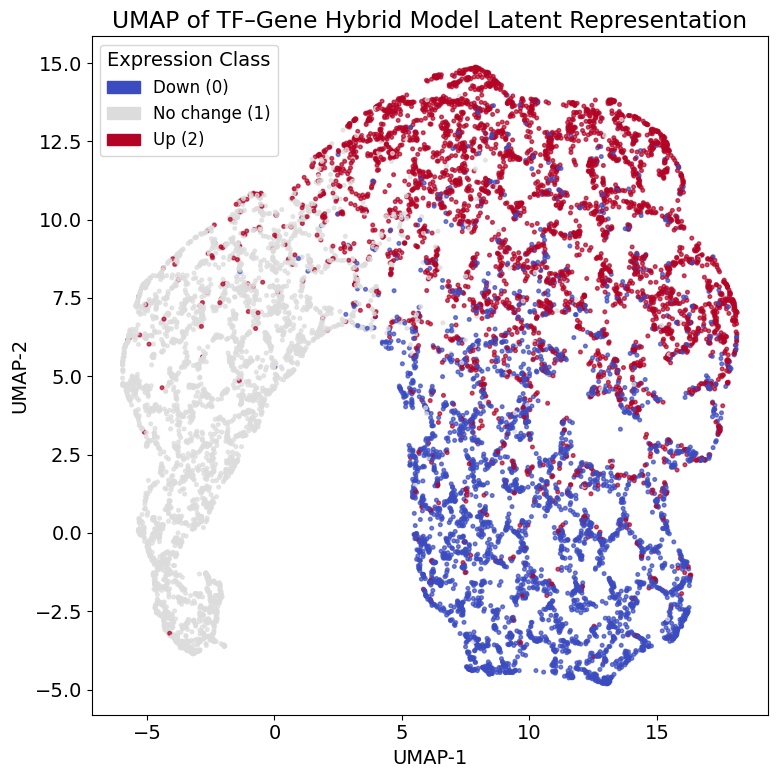

Saved UMAP plot to: results/umap_hybrid_latent.png


In [33]:
# =========================
# PLOT + LEGEND + SAVE
# =========================
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.figure(figsize=(8,8))
scatter = plt.scatter(
    umap_emb[:,0], umap_emb[:,1],
    c=labels,
    cmap="coolwarm",
    s=7,
    alpha=0.7
)

plt.title("UMAP of TF–Gene Hybrid Model Latent Representation")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.tight_layout()
plt.rcParams.update({'font.size': 14})


# =========================
# LEGEND (No colorbar)
# =========================
# define colors manually from the scatter colormap
cmap = plt.get_cmap("coolwarm")
class0_color = cmap(0.0)      # for label 0
class1_color = cmap(0.5)      # for label 1
class2_color = cmap(1.0)      # for label 2

legend_handles = [
    mpatches.Patch(color=class0_color, label="Down (0)"),
    mpatches.Patch(color=class1_color, label="No change (1)"),
    mpatches.Patch(color=class2_color, label="Up (2)")
]

# plt.legend(handles=legend_handles, title="Expression Class", loc="best")
plt.legend(
    handles=legend_handles,
    title="Expression Class",
    fontsize=12,        # ← legend label font size
    title_fontsize=14,  # ← legend title font size
    loc="best"
)

# =========================
# SAVE FIGURE
# =========================
save_path = "results/umap_hybrid_latent.png"
os.makedirs("results", exist_ok=True)
plt.savefig(save_path, dpi=300)

plt.show()

print(f"Saved UMAP plot to: {save_path}")
